In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('C:\\Users\lenovo\stock_details_5_years.csv')
print(f"Number of rows: {len(df)}")

Number of rows: 602962


In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


In [5]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Company'],
      dtype='object')

In [6]:
df["Company"].unique()

array(['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'LLY',
       'V', 'TSM', 'UNH', 'AVGO', 'NVO', 'JPM', 'WMT', 'XOM', 'MA', 'JNJ',
       'PG', 'ORCL', 'HD', 'ADBE', 'ASML', 'CVX', 'COST', 'TM', 'MRK',
       'KO', 'ABBV', 'BAC', 'PEP', 'FMX', 'CRM', 'SHEL', 'ACN', 'NFLX',
       'MCD', 'AMD', 'LIN', 'NVS', 'AZN', 'CSCO', 'TMO', 'BABA', 'INTC',
       'PDD', 'SAP', 'ABT', 'TMUS', 'PFE', 'DIS', 'NKE', 'CMCSA', 'DHR',
       'INTU', 'TTE', 'WFC', 'VZ', 'BHP', 'HDB', 'HSBC', 'PM', 'QCOM',
       'IBM', 'AMGN', 'TXN', 'NOW', 'BA', 'COP', 'UNP', 'BX', 'SPGI',
       'UPS', 'GE', 'MS', 'HON', 'CAT', 'AMAT', 'BUD', 'AXP', 'RY', 'NEE',
       'UL', 'SNY', 'RTX', 'T', 'LOW', 'SBUX', 'RIO', 'TD', 'SYK', 'BLK',
       'LMT', 'GS', 'ELV', 'ISRG', 'BKNG', 'SONY', 'MDT', 'PLD', 'SCHW',
       'DE', 'MUFG', 'BP', 'TJX', 'BMY', 'PBR', 'MMC', 'MDLZ', 'AMT',
       'PGR', 'LRCX', 'SHOP', 'ADP', 'EQNR', 'GILD', 'CB', 'ADI', 'PANW',
       'VRTX', 'ETN', 'UBS', 'CVS', 'C', 'REGN', 'KKR', 'M

In [7]:
# Check unique companies
print(f"Total companies: {df['Company'].nunique()}")
print(df['Company'].unique()[:10])  # Preview first 10

# Count rows per company
company_counts = df['Company'].value_counts()
print(company_counts.head(10))  # Top 10 companies by row count

Total companies: 491
['AAPL' 'MSFT' 'GOOGL' 'AMZN' 'NVDA' 'META' 'TSLA' 'LLY' 'V' 'TSM']
AAPL    1258
ARES    1258
FAST    1258
WCN     1258
FERG    1258
CSGP    1258
TTD     1258
VRSK    1258
FIS     1258
LYG     1258
Name: Company, dtype: int64


In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Company', 'Date']).reset_index(drop=True)

In [9]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [10]:
def add_features(group):
    group['MA14'] = group['Close'].rolling(window=14).mean()
    group['MA50'] = group['Close'].rolling(window=50).mean()
    group['RSI'] = compute_rsi(group['Close'])
    group = group.dropna()
    return group

In [11]:
df = df.groupby('Company').apply(add_features).reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,MA14,MA50,RSI
0,2019-02-12 00:00:00-05:00,74.226637,74.661556,73.869032,74.487587,2045500,0.0,0.0,A,72.701652,68.261641,83.129376
1,2019-02-13 00:00:00-05:00,74.777549,74.893524,74.168654,74.661568,1376400,0.0,0.0,A,73.051661,68.374847,82.375334
2,2019-02-14 00:00:00-05:00,74.419928,74.690545,73.956008,74.439255,1618100,0.0,0.0,A,73.284308,68.468568,75.568679
3,2019-02-15 00:00:00-05:00,75.028821,75.686036,74.874186,75.676376,1919700,0.0,0.0,A,73.631556,68.542296,83.577965
4,2019-02-19 00:00:00-05:00,75.386428,75.695705,74.816201,74.922508,2968000,0.0,0.0,A,73.904936,68.634883,74.811903


In [13]:
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA14', 'MA50', 'RSI']
normalized_dfs = []

for company in df['Company'].unique():
    company_df = df[df['Company'] == company].copy()
    scaler = MinMaxScaler()
    company_df[features_to_scale] = scaler.fit_transform(company_df[features_to_scale])
    normalized_dfs.append(company_df)

df_normalized = pd.concat(normalized_dfs).sort_values(['Company', 'Date']).reset_index(drop=True)

df_normalized.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,MA14,MA50,RSI
0,2019-02-12 00:00:00-05:00,0.108115,0.086809,0.124196,0.110689,0.124447,0.0,0.0,A,0.064585,0.000000,0.824028
1,2019-02-13 00:00:00-05:00,0.112911,0.088880,0.126801,0.112203,0.077498,0.0,0.0,A,0.067841,0.001191,0.815428
2,2019-02-14 00:00:00-05:00,0.109798,0.087068,0.124952,0.110268,0.094458,0.0,0.0,A,0.070005,0.002178,0.737794
3,2019-02-15 00:00:00-05:00,0.115099,0.095955,0.132936,0.121035,0.115620,0.0,0.0,A,0.073235,0.002954,0.829144
4,2019-02-19 00:00:00-05:00,0.118212,0.096041,0.132432,0.114474,0.189175,0.0,0.0,A,0.075778,0.003928,0.729163


In [14]:
df_normalized['Target'] = df_normalized.groupby('Company')['Close'].shift(-1)
df_normalized.dropna(inplace=True)
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA14', 'MA50', 'RSI']

X = df_normalized[feature_cols]
y = df_normalized['Target']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 462729, Test size: 115683


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------

In [2]:
df = pd.read_csv('C:\\Users\lenovo\stock_details_5_years.csv')

In [3]:
# 2) DATA PREPROCESSING
# -------------------------
df.columns = [c.strip() for c in df.columns]
date_col = [c for c in df.columns if c.lower() in ["date", "datetime", "timestamp"]][0]
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(by=date_col).drop_duplicates(subset=[date_col]).set_index(date_col)


In [4]:
# Identify OHLCV columns
def pick_column(*names):
    for name in names:
        for c in df.columns:
            if name in c.lower():
                return c
    return None

close_col = pick_column("close", "adj close", "closing price")

In [5]:
# Convert numeric columns
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "").str.strip(), errors="ignore")

# Fill missing values
df = df.fillna(method="ffill").fillna(method="bfill")

# -------------------------

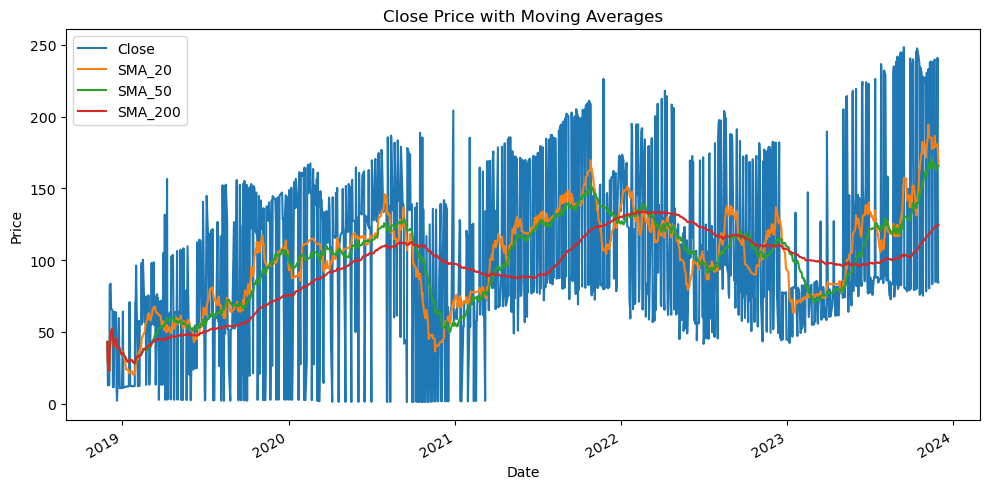

In [6]:
# 3) EXPLORATORY ANALYSIS
# -------------------------
if close_col:
    df["SMA_20"] = df[close_col].rolling(20, min_periods=1).mean()
    df["SMA_50"] = df[close_col].rolling(50, min_periods=1).mean()
    df["SMA_200"] = df[close_col].rolling(200, min_periods=1).mean()

    plt.figure(figsize=(10, 5))
    df[[close_col, "SMA_20", "SMA_50", "SMA_200"]].plot(ax=plt.gca())
    plt.title("Close Price with Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()


In [7]:
# 4) TRAIN-TEST SPLIT
# -------------------------
h = min(180, max(30, int(len(df) * 0.1)))  # last 10% as test
train = df.iloc[:-h]
test = df.iloc[-h:]

y_train = train[close_col].astype(float)
y_test = test[close_col].astype(float)

In [8]:
# 5) ARIMA/SARIMA MODEL
# -------------------------
model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 5),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)


C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [9]:
# Forecast
start = len(y_train)
end = start + len(y_test) - 1
pred = res.get_prediction(start=start, end=end, dynamic=False).predicted_mean
pred.index = y_test.index

C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 65.52
RMSE: 75.79
MAPE: 45.50%


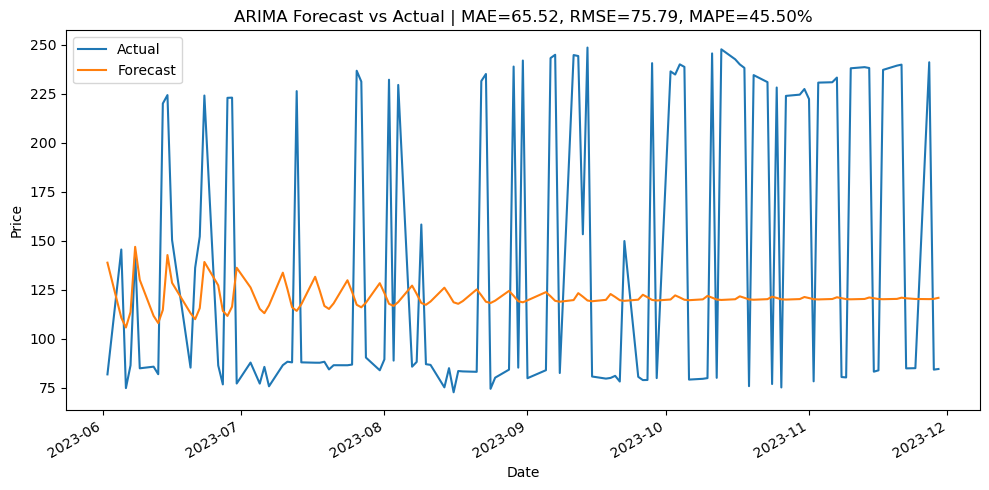

In [10]:
# 6) EVALUATION
# -------------------------
mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
mape = np.mean(np.abs((y_test - pred) / y_test)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(10, 5))
y_test.plot(label="Actual")
pred.plot(label="Forecast")
plt.title(f"ARIMA Forecast vs Actual | MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# -------------------------
# 7) SAVE OUTPUTS
# -------------------------
df.to_csv("stock_5y_clean.csv")
pd.DataFrame({"actual": y_test, "forecast": pred}).to_csv("arima_predictions.csv")

print("Saved: stock_5y_clean.csv & arima_predictions.csv")

Saved: stock_5y_clean.csv & arima_predictions.csv


In [1]:
# stock_forecasting_project.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Try to import Prophet (works with either 'prophet' or 'fbprophet')
try:
    from prophet import Prophet
except ImportError:
    try:
        from fbprophet import Prophet
    except ImportError:
        Prophet = None
        print("Prophet is not installed. Install it via: pip install prophet")


Prophet is not installed. Install it via: pip install prophet


In [4]:
 #1) LOAD DATA
# -------------------------
file_path = "stock_details_5_years.csv"  # update path if needed
df = pd.read_csv(file_path)

# 2) DATA PREPROCESSING
# -------------------------
df.columns = [c.strip() for c in df.columns]
date_col = [c for c in df.columns if c.lower() in ["date", "datetime", "timestamp"]][0]
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(by=date_col).drop_duplicates(subset=[date_col]).set_index(date_col)

def pick_column(*names):
    for name in names:
        for c in df.columns:
            if name in c.lower():
                return c
    return None

close_col = pick_column("close", "adj close", "closing price")

for c in df.columns:
    if df[c].dtype == "object":
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "").str.strip(), errors="ignore")

df = df.fillna(method="ffill").fillna(method="bfill")

# -------------------------

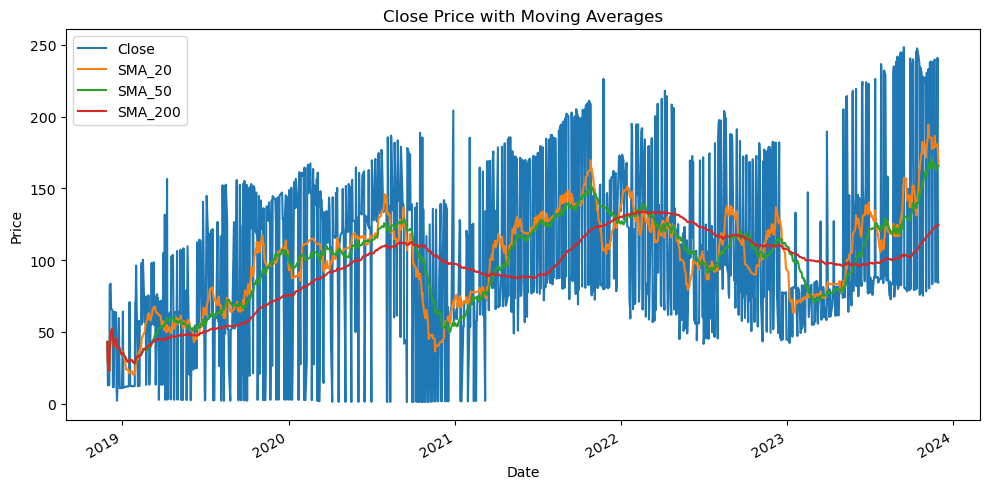

In [5]:
# -------------------------
# 3) EXPLORATORY ANALYSIS
# -------------------------
if close_col:
    df["SMA_20"] = df[close_col].rolling(20, min_periods=1).mean()
    df["SMA_50"] = df[close_col].rolling(50, min_periods=1).mean()
    df["SMA_200"] = df[close_col].rolling(200, min_periods=1).mean()

    plt.figure(figsize=(10, 5))
    df[[close_col, "SMA_20", "SMA_50", "SMA_200"]].plot(ax=plt.gca())
    plt.title("Close Price with Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()

In [11]:
# 4) TRAIN-TEST SPLIT
# -------------------------
h = min(180, max(30, int(len(df) * 0.1)))
train = df.iloc[:-h]
test = df.iloc[-h:]

y_train = train[close_col].astype(float)
y_test = test[close_col].astype(float)


C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: F

ARIMA MAE: 65.52, RMSE: 75.79, MAPE: 45.50%


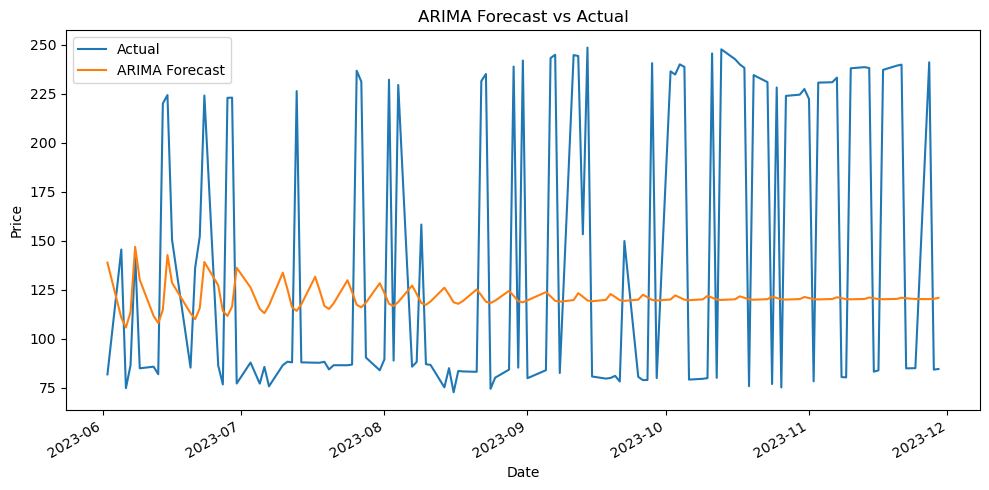

In [12]:
# 5) ARIMA/SARIMA MODEL
# -------------------------
model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 5),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

start = len(y_train)
end = start + len(y_test) - 1
pred_arima = res.get_prediction(start=start, end=end, dynamic=False).predicted_mean
pred_arima.index = y_test.index

mae_arima = mean_absolute_error(y_test, pred_arima)
rmse_arima = mean_squared_error(y_test, pred_arima, squared=False)
mape_arima = np.mean(np.abs((y_test - pred_arima) / y_test)) * 100

print(f"ARIMA MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}, MAPE: {mape_arima:.2f}%")

plt.figure(figsize=(10, 5))
y_test.plot(label="Actual")
pred_arima.plot(label="ARIMA Forecast")
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
 #6) PROPHET MODEL (if available)
# -------------------------
if Prophet:
    df_prophet = df[[close_col]].dropna().reset_index()
    df_prophet.columns = ["ds", "y"]

    train_prophet = df_prophet.iloc[:-h]
    test_prophet = df_prophet.iloc[-h:]

    m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
    m.fit(train_prophet)

    future = m.make_future_dataframe(periods=h, freq="D")
    forecast = m.predict(future)

    forecast_test = forecast.set_index("ds").loc[test_prophet["ds"], "yhat"]

    mae_prophet = mean_absolute_error(test_prophet["y"], forecast_test)
    rmse_prophet = mean_squared_error(test_prophet["y"], forecast_test, squared=False)
    mape_prophet = np.mean(np.abs((test_prophet["y"] - forecast_test) / test_prophet["y"])) * 100

    print(f"Prophet MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}, MAPE: {mape_prophet:.2f}%")

    plt.figure(figsize=(10, 5))
    test_prophet.set_index("ds")["y"].plot(label="Actual")
    forecast_test.plot(label="Prophet Forecast")
    plt.title("Prophet Forecast vs Actual")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [14]:
# 7) SAVE OUTPUTS
# -------------------------
df.to_csv("stock_5y_clean.csv")
pd.DataFrame({"actual": y_test, "forecast": pred_arima}).to_csv("arima_predictions.csv", index=True)
if Prophet:
    pd.DataFrame({"actual": test_prophet["y"].values,
                  "forecast": forecast_test.values,
                  "date": test_prophet["ds"].values}).to_csv("prophet_predictions.csv", index=False)

print("Saved: stock_5y_clean.csv, arima_predictions.csv", 
      "+ prophet_predictions.csv" if Prophet else "")


Saved: stock_5y_clean.csv, arima_predictions.csv 
